# Recommendation Systems Evolutionary Dynamics

## Imports

In [1]:
from recommendation_systems_evolutionary_dynamics import EGT
import numpy as np
import matplotlib.pylab as plt

## Initialize Populations

In [2]:
Ns = [50, 50, 50]
x, y, z = 0.01, 0.01, 0.01
fractionss = [[x,1-x], [y, 1-y], [z, 1-z]]
game = EGT.Game(Ns, fractionss)
P1, P2, P3 = game.get_populations()
print(f"P1: {np.unique_counts(P1)}")
print(f"P2: {np.unique_counts(P2)}")
print(f"P3: {np.unique_counts(P3)}")

P1: UniqueCountsResult(values=array([0, 1]), counts=array([ 1, 49]))
P2: UniqueCountsResult(values=array([0, 1]), counts=array([ 1, 49]))
P3: UniqueCountsResult(values=array([0, 1]), counts=array([ 1, 49]))


## Initialize Payoff Matrix

In [3]:
paramss = [[0.15, 0.15, 0.4, 0.8, 0.2], [0.15, 0.15, 0.4, 0, 0.2], [0.2, 0.5, 0.6, 0, 0.3]]
params = paramss[0] 
cs = params[0]
ct = params[1]
bs = params[2]
br = params[3]
alpha = params[4]

payoff_matrix = {(0, 0, 0): [0, alpha, alpha],
                 (0, 0, 1): [0, 0, 0],
                 (0, 1, 0): [0, -ct, 0],
                 (0, 1, 1): [0, alpha - ct, alpha],
                 (1, 0, 0): [0, alpha, alpha],
                 (1, 0, 1): [br - cs, 0, bs],
                 (1, 1, 0): [-cs, bs - ct, 0],
                 (1, 1, 1): [br - 2*cs, alpha + bs - ct, alpha + bs]}

game.set_payoff_matrix(payoff_matrix)
print(game.get_payoff_matrix())

{(0, 0, 0): [0, 0.2, 0.2], (0, 0, 1): [0, 0, 0], (0, 1, 0): [0, -0.15, 0], (0, 1, 1): [0, 0.05000000000000002, 0.2], (1, 0, 0): [0, 0.2, 0.2], (1, 0, 1): [0.65, 0, 0.4], (1, 1, 0): [-0.15, 0.25, 0], (1, 1, 1): [0.5, 0.45000000000000007, 0.6000000000000001]}


[[-1.00000000e+00  4.93019426e-02  8.14054872e-02 -1.00000000e+00
   6.66666667e-03 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00]
 [ 1.94086485e-05 -1.00000000e+00 -1.00000000e+00  2.12920206e-03
  -1.00000000e+00  1.16151333e-12 -1.00000000e+00 -1.00000000e+00]
 [ 8.95639808e-08 -1.00000000e+00 -1.00000000e+00  1.94086485e-05
  -1.00000000e+00 -1.00000000e+00  3.77868520e-02 -1.00000000e+00]
 [-1.00000000e+00  1.51159018e-02  4.93019426e-02 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00 -1.00000000e+00  3.37908753e-10]
 [ 6.66666667e-03 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00  1.94086485e-05  2.12920206e-03 -1.00000000e+00]
 [-1.00000000e+00  1.35159817e-01 -1.00000000e+00 -1.00000000e+00
   4.93019426e-02 -1.00000000e+00 -1.00000000e+00  2.19986610e-09]
 [-1.00000000e+00 -1.00000000e+00  1.05606138e-04 -1.00000000e+00
   1.51159018e-02 -1.00000000e+00 -1.00000000e+00  7.75254586e-12]
 [-1.00000000e+00 -1.00000000e+00 -1.00000000e+00  1.09893318e-01
  -

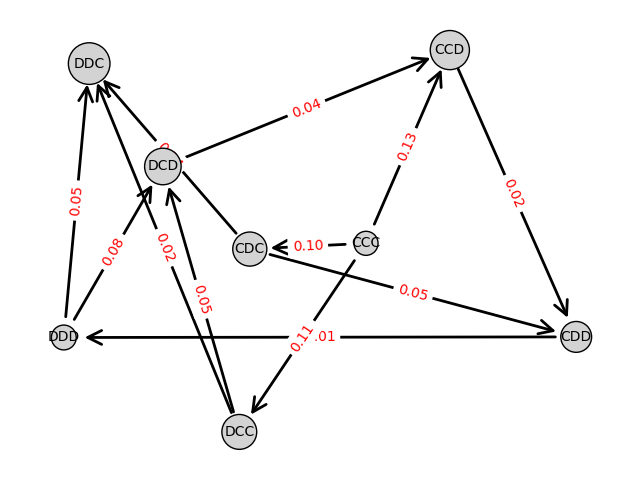

In [4]:
matrix = np.random.rand(8, 8) / 10
matrix = game.compute_trans_matrix(beta=0.8)
print(matrix)
game.plot_transition_matrix(matrix)

## Birth_Death

In [4]:
Ns = [50, 50, 50]
x, y, z = 0.1, 0.1, 0.1  # Cs
fractionss = [[1-x, x], [1-y, y], [1-z, z]]
game = EGT.Game(Ns, fractionss)
paramss = [[0.15, 0.15, 0.4, 0.8, 0.2], [0.15, 0.15, 0.4, 0, 0.2], [0.2, 0.5, 0.6, 0, 0.3]]
params = paramss[0]
cs = params[0]
ct = params[1]
bs = params[2]
br = params[3]
alpha = params[4]

payoff_matrix = {(0, 0, 0): [0, alpha, alpha],
                 (0, 0, 1): [0, 0, 0],
                 (0, 1, 0): [0, -ct, 0],
                 (0, 1, 1): [0, alpha - ct, alpha],
                 (1, 0, 0): [0, alpha, alpha],
                 (1, 0, 1): [br - cs, 0, bs],
                 (1, 1, 0): [-cs, bs - ct, 0],
                 (1, 1, 1): [br - 2 * cs, alpha + bs - ct, alpha + bs]}

game.set_payoff_matrix(payoff_matrix)

steps = 1000
rep = 100

mean_fractionss_hist, fractionss_hist, Ps_hist = game.birth_death(rep=rep, steps=steps, beta=10, u=0.1, return_hist=True, print_rep_interval=20)
mean_fractionss_hist = mean_fractionss_hist[:, :, 1]
len(Ps_hist)

Replicate: 0
Replicate: 20
Replicate: 40
Replicate: 60
Replicate: 80


3

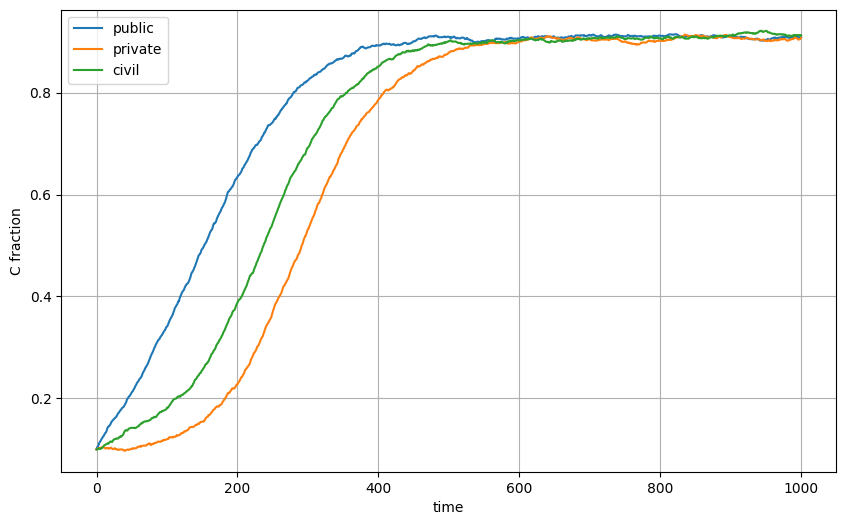

In [5]:
game.visualize_evol(mean_fractionss_hist, players=["public", "private", "civil"], xlabel="time", ylabel="C fraction")

## Stationary Distribution

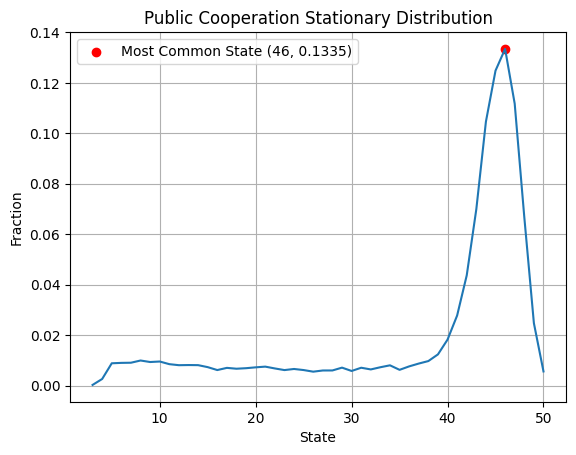

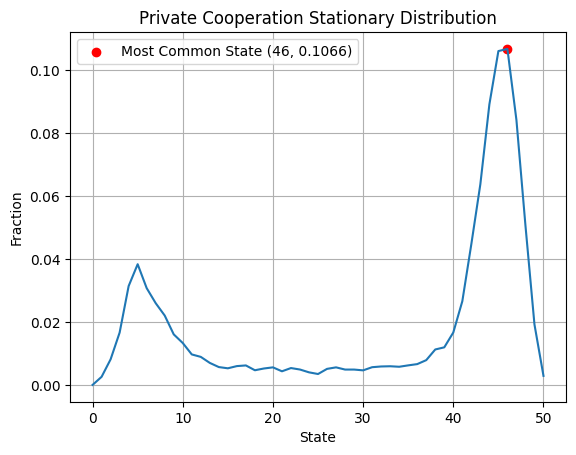

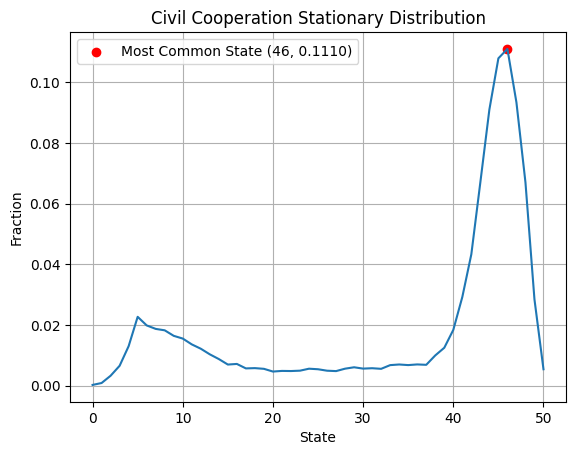

In [6]:
game.visualize_stationary_dist(Ps_hist=Ps_hist[0], title="Public Cooperation Stationary Distribution")
game.visualize_stationary_dist(Ps_hist=Ps_hist[1], title="Private Cooperation Stationary Distribution")
game.visualize_stationary_dist(Ps_hist=Ps_hist[2], title="Civil Cooperation Stationary Distribution")

In [29]:
a = (1,2,0)
b = (1,0,2)


    return dist
dist(a,b)

2